# Training Logistic Regression via Stochastic Gradient Ascent

 * Extract features from Amazon product reviews.
 * Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
 * Implement stochastic gradient ascent.
 * Compare convergence of stochastic gradient ascent with that of batch gradient ascent.

## Load and process review dataset

In [1]:
import numpy as np
import pandas as pd
import string

In [2]:
dtype_dict = {'name':str,
              'review':str, 
              'rating':int,
              'sentiment':int}

In [3]:
products = pd.read_csv('amazon_baby_subset.csv', dtype = dtype_dict)
#products = pd.read_csv('amazon_baby_subset.csv')

In [4]:
products.head(2)

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1


In [5]:
import json
with open('important_words.json', 'r') as f: 
    important_words = json.load(f)
# important_words = [str(s) for s in important_words]

In [6]:
len(important_words)

193

In [7]:
# Remote punctuation
def remove_punctuation(text):
    ## in PYthon 2
    # return text.translate(None, string.punctuation) 
    ## python 3
    table = str.maketrans({key: None for key in string.punctuation})
    return str(text).translate(table) 

products['review_clean'] = products['review'].apply(remove_punctuation)

In [8]:
products.head(2)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...


In [9]:
products['review_clean'] = products['review_clean'].apply(lambda review: review.lower())

In [10]:
products.head(2)

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,all of my kids have cried nonstop when i tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,we wanted to get something to keep track of ou...


In [11]:
# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [12]:
products.head(1)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,all of my kids have cried nonstop when i tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split data into training and validation sets

We will now split the data into a 90-10 split where 90% is in the training set and 10% is in the validation set. We use `seed=1` so that everyone gets the same result.

In [13]:
with open('train-idx.json', 'r') as f:
    train_index= json.load(f)
    
    
with open('validation-idx.json', 'r') as f:
    test_index = json.load(f)

In [14]:
train_data = products.iloc[train_index]

validation_data = products.iloc[test_index]

In [15]:
print(train_data.shape)
print(validation_data.shape)

(47780, 198)
(5292, 198)


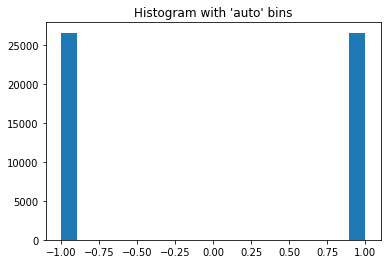

In [16]:
import matplotlib.pyplot as plt
plt.hist(products['sentiment'].values, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [17]:
print(sum(products['sentiment']==1))
print(sum(products['sentiment']!=1))

26579
26493


In [26]:
#important_words = [str(s) for s in important_words]
important_words=[]
with open('important_words.json', 'r') as f: 
    important_words = json.load(f) 

In [102]:
def get_numpy_data(data, features, label):
    #data['intercept'] = 1
    #print(data.columns.values)
    features = ['intercept'] + features
    #features_matrix= pd.DataFrame()
    features_matrix = data.loc[:,(features)].values
    #label_array= pd.DataFrame()
    #feature_matrix = features_sframe.to_numpy()
    label_array = data.loc[:,label].values
    #label_array = label_sarray.to_numpy()
    return(features_matrix, label_array)

In [81]:
train_data.shape

(47781, 199)

### Solving the problem of adding constant values to a large DataFrame

In [103]:
#train_data['intercept'] =  1
#df1.assign(e = Series(np.random.randn(sLength), index=df1.index))
train_data.assign(intercept = pd.Series(np.ones(len(train_data['sentiment'])), index = train_data.index))
validation_data.assign(intercept = pd.Series(np.ones(len(validation_data['sentiment'])), index = validation_data.index))
print()

In [97]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

## Building on logistic regression

Logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

In [98]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

## Derivative of log likelihood with respect to a single coefficient

**the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

We wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 
Complete the following code block:

In [99]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(feature, errors)

    return derivative

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

In [100]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

## Modifying the derivative for stochastic gradient ascent

Gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


** Computing the gradient for a single data point**

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$? 


Thankfully **No!**. Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [105]:
feature_matrix_train.shape

(47781, 194)

In [111]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train.values[i:i+1,:], coefficients)
indicator = (sentiment_train.values[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train.values[i:i+1,j])
print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


## Modifying the derivative for using a batch of data points

Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$


** Computing the gradient for a "mini-batch" of data points**

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using `feature_matrix_train[i:i+B,:]`
and $y_i$ in the training data using `sentiment_train[i:i+B]`. 

We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [112]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train.values[i:i+B,:], coefficients)
indicator = (sentiment_train.values[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train.values[i:i+B,j])
print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

In [134]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] +=  1./ batch_size * derivative * step_size
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        # if we made a complete pass over data, shuffle and restart
        i = i + batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

### Checkpoint

The following cell tests your stochastic gradient ascent function using a toy dataset consisting of two data points. If the test does not pass, make sure you are normalizing the gradient update rule correctly.

In [135]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## Compare convergence behavior of stochastic gradient ascent
### Running gradient ascent using the stochastic gradient ascent implementation

Stochastic gradient ascent over the feature_matrix_train for 10 iterations using

In [137]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train.values, sentiment_train.values,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.00861448
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.01127332
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.00240655
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.00544615
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.26579199
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04790356
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.06796997
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.00080891
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.03955332
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00827563


Now run **batch gradient ascent** over the **feature_matrix_train** for 200 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = len(feature_matrix_train)`
* `max_iter = 200`

In [138]:
coefficients_batch, log_likelihood_batch =  logistic_regression_SG(feature_matrix_train.values, sentiment_train.values,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47781]) = -0.68101838
Iteration   1: Average log likelihood (of data points in batch [00000:47781]) = -0.67006838
Iteration   2: Average log likelihood (of data points in batch [00000:47781]) = -0.66007709
Iteration   3: Average log likelihood (of data points in batch [00000:47781]) = -0.65091590
Iteration   4: Average log likelihood (of data points in batch [00000:47781]) = -0.64248518
Iteration   5: Average log likelihood (of data points in batch [00000:47781]) = -0.63470113
Iteration   6: Average log likelihood (of data points in batch [00000:47781]) = -0.62749186
Iteration   7: Average log likelihood (of data points in batch [00000:47781]) = -0.62079531
Iteration   8: Average log likelihood (of data points in batch [00000:47781]) = -0.61455772
Iteration   9: Average log likelihood (of data points in batch [00000:47781]) = -0.60873238
Iteration  10: Average log likelihood (of data points in batch [00000:47781]) = 

## Make "passes" over the dataset

## Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [140]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train.values, sentiment_train.values,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68548449
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.68457500
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.67607102
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67557110
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67580866
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67824731
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66774436
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67502771
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66027557
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.66800224
Iteration   10: Average log likelihood (of data points in batch [01000

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

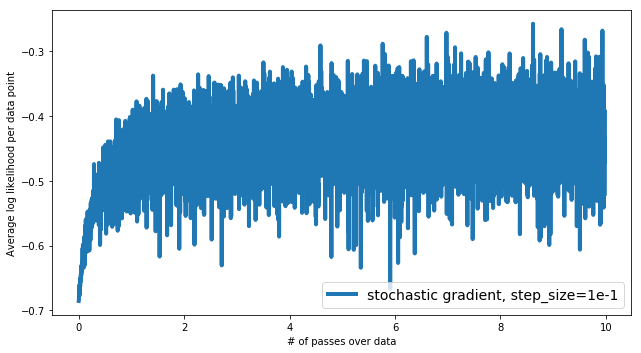

In [142]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

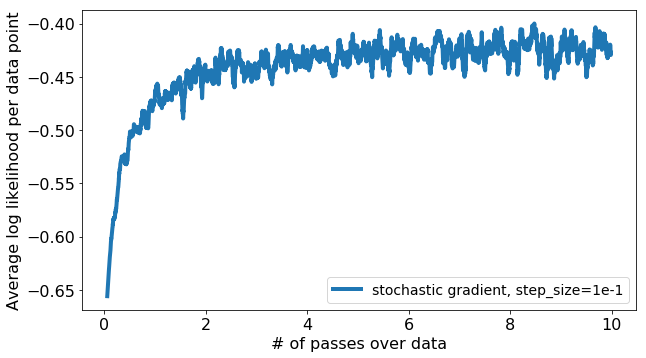

In [143]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [145]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train.values, sentiment_train.values,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68548449
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.68457500
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.67607102
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67557110
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67580866
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67824731
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66774436
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67502771
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66027557
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.66800224
Iteration    10: Average log likelihood (of data points in b

In [155]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train.values, sentiment_train.values,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47781]) = -0.69066721
Iteration   1: Average log likelihood (of data points in batch [00000:47781]) = -0.68824003
Iteration   2: Average log likelihood (of data points in batch [00000:47781]) = -0.68586288
Iteration   3: Average log likelihood (of data points in batch [00000:47781]) = -0.68353338
Iteration   4: Average log likelihood (of data points in batch [00000:47781]) = -0.68124943
Iteration   5: Average log likelihood (of data points in batch [00000:47781]) = -0.67900920
Iteration   6: Average log likelihood (of data points in batch [00000:47781]) = -0.67681104
Iteration   7: Average log likelihood (of data points in batch [00000:47781]) = -0.67465347
Iteration   8: Average log likelihood (of data points in batch [00000:47781]) = -0.67253513
Iteration   9: Average log likelihood (of data points in batch [00000:47781]) = -0.67045478
Iteration  10: Average log likelihood (of data points in batch [00000:47781]) = 

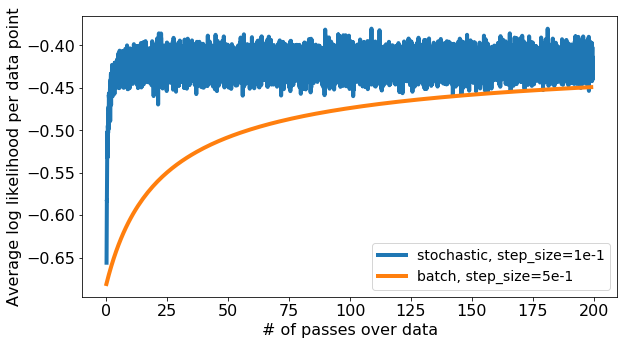

In [148]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

## Explore the effects of step sizes on stochastic gradient ascent

Run stochastic gradient ascent with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. Use the following set of parameters:
* `initial_coefficients=np.zeros(194)`
* `batch_size=100`
* `max_iter` initialized so as to run 10 passes over the data.

In [150]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train.values, sentiment_train.values,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313930
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313851
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69312943
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312841
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69312897
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313153
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69312066
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312754
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69311040
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69311887
Iteration   10: Average log likelihood (of data points in batch [01000

Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -0.45763074
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68548449
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.68457500
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.67607102
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67557110
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67580866
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67824731
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66774436
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67502771
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66027557
Iteration    9: Average log likelihood (of data points in batch [00900

Iteration 4000: Average log likelihood (of data points in batch [18400:18500]) = -0.70252806
Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -1.53093891
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.74585792
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -5.64290170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -44.61547128
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -16.18948835
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -17.37146724
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -23.72741240
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -29.36065902
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -17.09720403
Iteration    8: Average log likelihood (of data points in batch 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Iteration  200: Average log likelihood (of data points in batch [20000:20100]) = -2.06996651
Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -14.17993524


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -3.50978258
Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -5.63918586
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -10.47897120
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -3.77081212
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -5.69548109
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -7.58653427
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -6.05362509
Iteration 2000: Average log likelihood (of data points in batch [09200:09300]) = -5.86722565
Iteration 3000: Average log likelihood (of data points in batch [13800:13900]) = -18.59358924
Iteration 4000: Average log likelihood (of data points in batch [18400:18500]) = -6.03480693
Iteration 4769: Average log likelihood (of data points in batch [476

### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

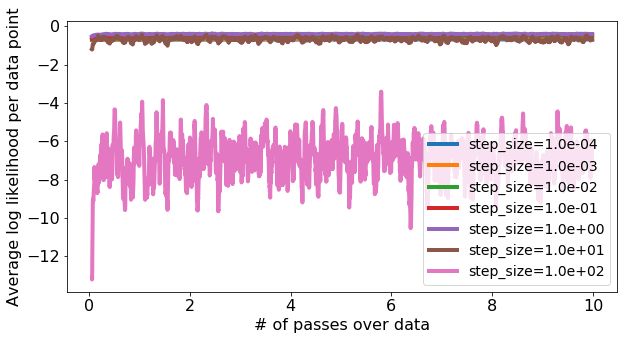

In [151]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

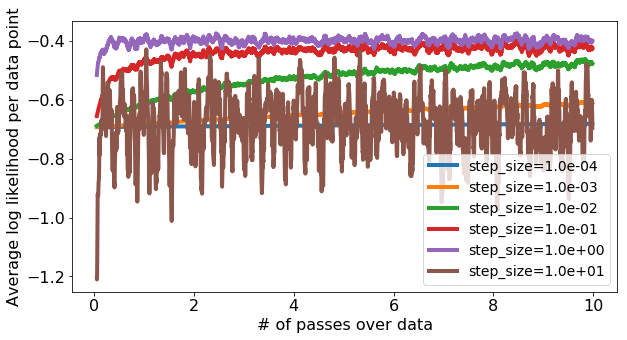

In [152]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)